In [37]:
from sodapy import Socrata

import numpy as np
import pandas as pd

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

In [159]:
def combine_school_datasets():
    
    df = pd.read_csv("acs_income_dataset.csv")
    
    df = df.rename(columns=df.iloc[0])
    
    df = df.iloc[1:]
    
    zips = df['Geography'].tolist()
    
    zips = [code.split() for code in zips]
    
    zips = [sublist[1] for sublist in zips]
    
    df['Geography'] = zips
    
    df = df[['Geography','Number; Estimate; Households',
         'Median income (dollars); Estimate; Households']]
    
    df['Number; Estimate; Households'] \
    = pd.to_numeric(df['Number; Estimate; Households'],
                    errors='coerce')
    df['Median income (dollars); Estimate; Households'] \
    = pd.to_numeric(df['Median income (dollars); Estimate; Households'],
                    errors='coerce')    

    df1 = pd.read_csv('NJPubSchoolDistricts.csv')
    
    df1 = df1.merge(df,left_on=" Zip", right_on="Geography")
    
    df = df1[[' Zip',' District Code',' City','Number; Estimate; Households',
             'Median income (dollars); Estimate; Households']]
    
    df2 = pd.read_excel('district.xlsx')
    
    df = df.merge(df2, left_on=" District Code", right_on="Dist")
    
    df = df.drop([" District Code","County",
             "One Year\nK-12 Aid\nDifference",
             "One Year Aid Percent Difference",
                 '2018-19 Approp. Act Revised Total K-12 Aid2'], axis=1)
    
    df3 = pd.read_excel("DistrictPerformanceReports.xlsx",
                    sheet_name="ViolenceVandalismHIBSubstanceOf")
    
    df3["District_Code"] = pd.to_numeric(df3["District_Code"], errors='coerce')
    
    df = df.merge(df3, left_on="Dist", right_on='District_Code')
    
    df = df.drop(['District_Code', 'District'],axis=1)
    
    df4 = pd.read_excel("DistrictPerformanceReports.xlsx",
                    sheet_name="StudentSuspensionRates")
    
    df4["District_Code"] = pd.to_numeric(df4["District_Code"], errors='coerce')
    
    df4 = df4.drop(['County_Code'],axis=1)
    
    df = df.merge(df4, left_on="Dist", right_on='District_Code')
    
    df = df.drop(['District_Code'],axis=1)
    
    df5 = pd.read_excel("DistrictPerformanceReports.xlsx",
                    sheet_name="TeachersExperienceCertification")
    
    df5["District_Code"] = pd.to_numeric(df5["District_Code"], errors='coerce')
    
    df5 = df5[['District_Code','TeacherCount']]
    
    df = df.merge(df5, left_on="Dist", right_on='District_Code')
    
    df = df.drop(['District_Code'],axis=1)
    
    df.columns = ['zip_code', 'city', 'num_of_households', 'median_income_per_household',
       'district_code', 'district', 'total_k_12_aid_2017_18',
       'governors_budget_message_total_aid_2018_19', 'revised_total_k_12_aid',
       'equalization_aid', 'educational_adequacy_aid', 'choice_aid',
       'transportation_aid', 'special_education_aid', 'security_aid',
       'adjustment_aid','violence','vandalism','weapons','substances',
                  'harassment_intimidation_bullying',
                   'total_unique_incidents','incidents_per_100_students',
                 'in_school_suspension_rate','out_school_suspension_rate',
                 'student_suspension_rate','teacher_count']
    
    df["adjustment_aid"] = pd.to_numeric(df["adjustment_aid"], errors='coerce')   
    df["in_school_suspension_rate"] = pd.to_numeric(df["in_school_suspension_rate"], errors='coerce')
    df["out_school_suspension_rate"] = pd.to_numeric(df["out_school_suspension_rate"], errors='coerce')
    df["student_suspension_rate"] = pd.to_numeric(df["student_suspension_rate"], errors='coerce')
    df["teacher_count"] = pd.to_numeric(df["teacher_count"], errors='coerce')

    df.to_pickle("nj_school_dataset.csv")

In [160]:
combine_school_datasets()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2909: DtypeWarning: Columns (1,3,4,5,6,9,10,15,16,21,22,27,28,33,34,39,40,45,46,51,52,57,58,63,64,69,70,75,76,81,82,87,88,89,90,93,94,99,100,105,106,111,112,117,118,123,124,129,130,135,136,177,178,183,184,189,190,195,196,201,202,203,204,207,208,213,214,219,220,225,226,231,232,237,238) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [161]:
df = pd.read_pickle("nj_school_dataset.csv")

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469 entries, 0 to 468
Data columns (total 27 columns):
zip_code                                      469 non-null object
city                                          469 non-null object
num_of_households                             469 non-null int64
median_income_per_household                   465 non-null float64
district_code                                 469 non-null float64
district                                      469 non-null float64
total_k_12_aid_2017_18                        469 non-null float64
governors_budget_message_total_aid_2018_19    469 non-null float64
revised_total_k_12_aid                        469 non-null float64
equalization_aid                              469 non-null float64
educational_adequacy_aid                      469 non-null float64
choice_aid                                    469 non-null float64
transportation_aid                            469 non-null float64
special_education_aid       

In [273]:
def heatmap():
    
    df = pd.read_pickle("nj_school_dataset.csv")
    
    data = df.drop(['city','zip_code'],axis=1)
    
    data = data[data['median_income_per_household'].notnull()]
    data = data[data['student_suspension_rate'].notnull()]
    
    corr = data.corr()
    plt.figure(figsize = (10,10))
    sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

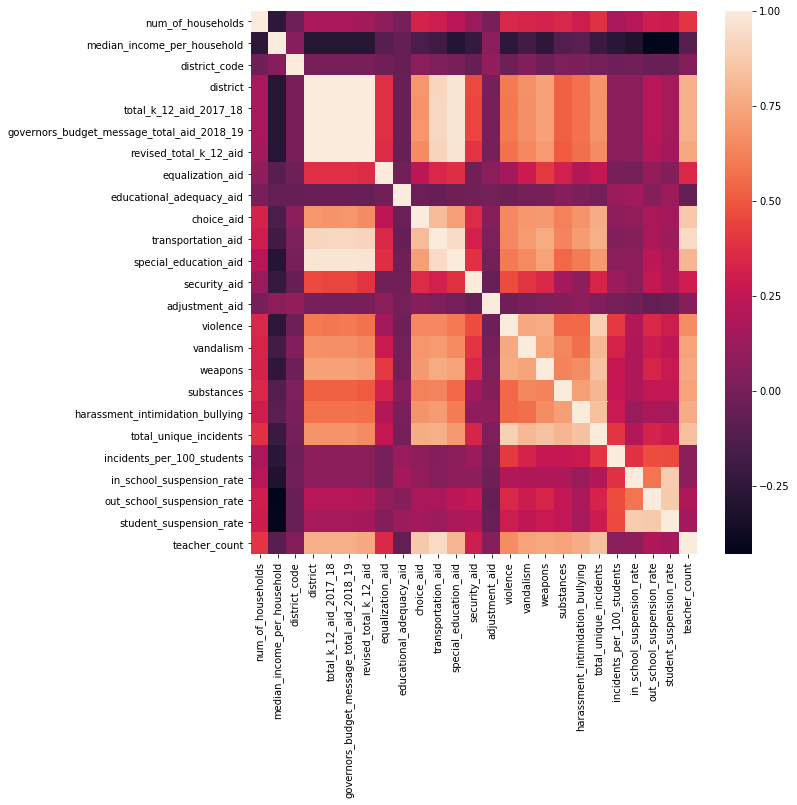

In [274]:
heatmap()

In [288]:
def eda():
    
    df = pd.read_pickle("nj_school_dataset.csv")
    
    data = df.drop(['city','zip_code'],axis=1)
    
    data = data[data['median_income_per_household'].notnull()]
    data = data[data['student_suspension_rate'].notnull()]
    
    for column in ['weapons',
                   'vandalism',
                   'harassment_intimidation_bullying',
                   'substances',
                   'total_unique_incidents']:
        plt.scatter(data[column], data['teacher_count'], label=column)
        plt.legend()
        
        plt.show()    

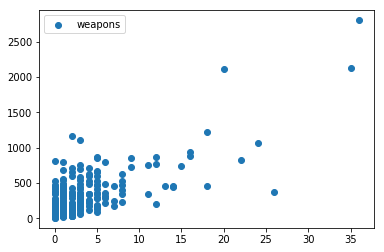

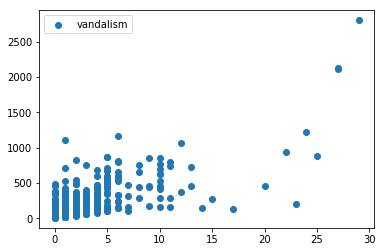

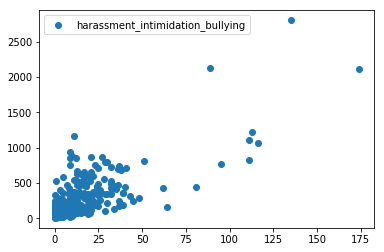

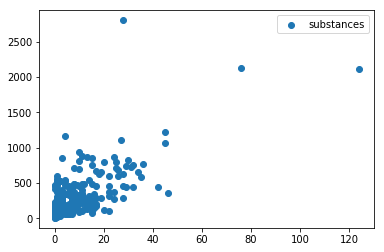

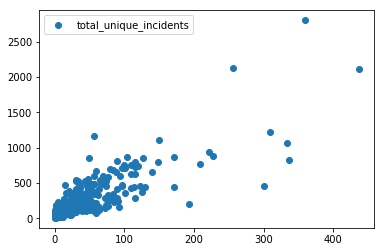

In [289]:
eda()

In [292]:
def stats_model_regression():
    
    df = pd.read_pickle("nj_school_dataset.csv")
    
    data = df.drop(['city','zip_code'],axis=1)
    
    data = data[data['median_income_per_household'].notnull()]
    data = data[data['student_suspension_rate'].notnull()]
    data = data[data['teacher_count'].notnull()]
    
    y = data['teacher_count']
    X = data[['weapons',
              'vandalism',
              'harassment_intimidation_bullying',
              'substances',
              'total_unique_incidents']]
    
    model = sm.OLS(y, X).fit()
    
    predictions = model.predict(X)
    
    return model.summary()

In [293]:
stats_model_regression()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          teacher_count   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     435.5
Date:                Wed, 13 Feb 2019   Prob (F-statistic):          2.85e-171
Time:                        19:34:58   Log-Likelihood:                -2948.4
No. Observations:                 462   AIC:                             5907.
Df Residuals:                     457   BIC:                             5928.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
weapons                             12.2706      3.115      3.939      0.000       6.149      18.393
vandalism                           19.0660      2.945      6.474      0.000      13.278      24.854
harassment_intimidation_bullying     5.7268      0.731      7.830      0.000       4.289       7.164
substances                           4.2916      1.098      3.908      0.000       2.133       6.450
total_unique_incidents               0.4401      0.447      0.984      0.326      -0.439       1.319
==============================================================================
Omnibus:                       89.508   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1305.473
Skew:                           0.299   Prob(JB):                    3.31e-284
Kurtosis:                      11.213   Cond. No.                         31.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [304]:
def sklearn_regression():
    
    df = pd.read_pickle("nj_school_dataset.csv")
    
    data = df.drop(['city','zip_code'],axis=1)
    
    data = data[data['median_income_per_household'].notnull()]
    data = data[data['student_suspension_rate'].notnull()]
    data = data[data['teacher_count'].notnull()]
    
    y = data['teacher_count']
    X = data[['weapons',
              'vandalism',
              'harassment_intimidation_bullying',
              'substances']]
    
    reg = LinearRegression()
    
    model = reg.fit(X,y)
    
    predictions = reg.predict(X)
    
    return reg.score(X,y)

In [305]:
sklearn_regression()

0.7568926455740488

In [306]:
def machine_learning():
    
    df = pd.read_pickle("nj_school_dataset.csv")
    
    data = df.drop(['city','zip_code'],axis=1)
    
    data = data[data['median_income_per_household'].notnull()]
    data = data[data['student_suspension_rate'].notnull()]
    data = data[data['teacher_count'].notnull()]
    
    y = data['teacher_count']
    X = data[['weapons',
              'substances',
              'vandalism',
              'harassment_intimidation_bullying']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=53)
    
    reg = LinearRegression()
    
    model = reg.fit(X_train, y_train)
    
    predictions = reg.predict(X_test)
    
    plt.scatter(y_test, predictions)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.plot(color='black', linewidth=3)
    plt.show()
    
    print("Score: ", model.score(X_test, y_test))

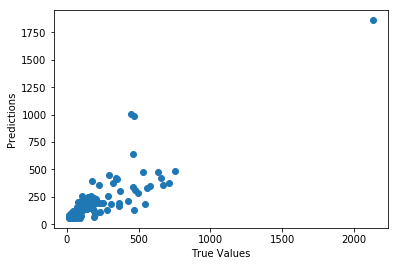

Score:  0.7355481851951653


In [307]:
machine_learning()